# 1. Feature Selection (Forward-Backward-Stepwise)

In [123]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [120]:
import warnings
from sklearn.exceptions import ConvergenceWarning

In [55]:
df = pd.read_csv('../1_data/data_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Columns: 451 entries, air_time1 to class
dtypes: float64(300), int64(150), object(1)
memory usage: 613.2+ KB


In [19]:
X = df.drop(columns=['class'])
y = df['class']

In [20]:
X = X.apply(pd.to_numeric, errors='coerce')

In [31]:
X.head()

,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,mean_jerk_in_air1,...,mean_gmrt25,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25
0,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,0.051836,...,249.729085,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605
1,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,0.039827,...,77.258394,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640
2,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,0.064220,...,193.667018,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025
3,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,0.090408,...,163.065803,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220
4,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,0.037528,...,147.094679,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575


In [32]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import PerfectSeparationError
from sklearn.linear_model import LogisticRegression

### 1.1. Forward Elimination

In [124]:
def forward_selection(X, y):
    initial_features = X.columns.tolist()
    best_features = []
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features, dtype=float)
        for new_column in remaining_features:
            try:
                X_model = sm.add_constant(X[best_features + [new_column]]).to_numpy()
                y_model = y.to_numpy()
                model = sm.Logit(y_model, X_model).fit(disp=0)
                new_pval[new_column] = model.pvalues[1]  # p-values are returned with constant first
            except (PerfectSeparationError, np.linalg.LinAlgError):
                new_pval[new_column] = np.nan
        min_p_value = new_pval.min()
        if min_p_value < 0.05:  # Choose your significance level here
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

fw_features = forward_selection(X_train, y_train)
print("Selected features (Forward Selection):", fw_features)

Selected features (Forward Selection): ['disp_index24', 'num_of_pendown24', 'mean_speed_in_air2', 'paper_time19', 'mean_speed_on_paper19', 'max_y_extension15', 'max_y_extension18', 'mean_acc_in_air5', 'mean_speed_on_paper24', 'gmrt_in_air2', 'pressure_var6', 'max_x_extension11', 'disp_index18', 'mean_acc_on_paper19', 'pressure_var15', 'pressure_var7', 'gmrt_on_paper4', 'mean_speed_in_air11', 'disp_index15', 'pressure_var11', 'pressure_var25', 'pressure_var12', 'mean_jerk_in_air5', 'mean_jerk_in_air18', 'gmrt_in_air4', 'mean_gmrt4', 'mean_acc_in_air22', 'num_of_pendown5', 'mean_acc_in_air21', 'gmrt_in_air20', 'gmrt_on_paper8', 'num_of_pendown21', 'pressure_var10', 'disp_index11', 'mean_jerk_on_paper10', 'disp_index22', 'paper_time16', 'mean_speed_on_paper5', 'max_x_extension10', 'num_of_pendown4', 'pressure_mean10', 'mean_jerk_in_air11', 'disp_index6', 'max_y_extension21', 'paper_time1', 'disp_index7', 'disp_index1', 'mean_jerk_in_air3', 'gmrt_in_air3', 'mean_jerk_on_paper18', 'disp_ind

### 1.2. Backward Elimination

In [125]:
def backward_selection(X, y):
    features = X.columns.tolist()
    while len(features) > 0:
        try:
            X_model = sm.add_constant(X[features]).to_numpy()
            y_model = y.to_numpy()
            model = sm.Logit(y_model, X_model).fit(disp=0)
            pvalues = model.pvalues[1:]  # Exclude the intercept p-value
            max_p_value = pvalues.max()
            if max_p_value > 0.05:  # Choose your significance level here
                excluded_feature = pvalues.idxmax()
                features.remove(excluded_feature)
                print('Drop {:30} with p-value {:.6}'.format(excluded_feature, max_p_value))
            else:
                break
        except (PerfectSeparationError, np.linalg.LinAlgError):
            # If there is an error in model fitting, remove one feature at a time to identify the problematic feature
            for feature in features:
                try:
                    temp_features = features.copy()
                    temp_features.remove(feature)
                    X_model = sm.add_constant(X[temp_features]).to_numpy()
                    model = sm.Logit(y, X_model).fit(disp=0)
                except (PerfectSeparationError, np.linalg.LinAlgError):
                    features.remove(feature)
                    print('Dropped problematic feature: {}'.format(feature))
                    break
            else:
                break  # Break the loop if no single feature is causing the issue
    return features

back_features = backward_selection(X_train, y_train)
print("Selected features (Backward Selection):", back_features)

Selected features (Backward Selection): ['air_time1', 'disp_index1', 'gmrt_in_air1', 'gmrt_on_paper1', 'max_x_extension1', 'max_y_extension1', 'mean_acc_in_air1', 'mean_acc_on_paper1', 'mean_gmrt1', 'mean_jerk_in_air1', 'mean_jerk_on_paper1', 'mean_speed_in_air1', 'mean_speed_on_paper1', 'num_of_pendown1', 'paper_time1', 'pressure_mean1', 'pressure_var1', 'total_time1', 'air_time2', 'disp_index2', 'gmrt_in_air2', 'gmrt_on_paper2', 'max_x_extension2', 'max_y_extension2', 'mean_acc_in_air2', 'mean_acc_on_paper2', 'mean_gmrt2', 'mean_jerk_in_air2', 'mean_jerk_on_paper2', 'mean_speed_in_air2', 'mean_speed_on_paper2', 'num_of_pendown2', 'paper_time2', 'pressure_mean2', 'pressure_var2', 'total_time2', 'air_time3', 'disp_index3', 'gmrt_in_air3', 'gmrt_on_paper3', 'max_x_extension3', 'max_y_extension3', 'mean_acc_in_air3', 'mean_acc_on_paper3', 'mean_gmrt3', 'mean_jerk_in_air3', 'mean_jerk_on_paper3', 'mean_speed_in_air3', 'mean_speed_on_paper3', 'num_of_pendown3', 'paper_time3', 'pressure_mea

### 1.3. Stepwise Elimination

In [126]:
def stepwise_selection(X, y, initial_list=[], threshold_in=0.05, threshold_out=0.10, verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (default is empty)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    """
    included = list(initial_list)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            try:
                model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit(disp=0)
                new_pval[new_column] = model.pvalues[new_column]
            except (PerfectSeparationError, np.linalg.LinAlgError):
                new_pval[new_column] = np.nan
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        
        # backward step
        try:
            model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit(disp=0)
            # use all coefs except intercept
            pvalues = model.pvalues.iloc[1:]
            worst_pval = pvalues.max()
            if worst_pval > threshold_out:
                changed = True
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                if verbose:
                    print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        except (PerfectSeparationError, np.linalg.LinAlgError):
            break
        
        if not changed:
            break
    return included

stp_features = stepwise_selection(X_train, y_train)
print("Selected features:", stp_features)

Add  disp_index24                   with p-value 2.17404e-08
Add  total_time11                   with p-value 5.21763e-07
Add  max_x_extension22              with p-value 3.08313e-05
Add  disp_index25                   with p-value 2.95319e-05
Add  gmrt_in_air23                  with p-value 6.80088e-05
Drop disp_index24                   with p-value 0.398866
Add  mean_acc_on_paper9             with p-value 0.000134615
Add  num_of_pendown19               with p-value 0.00062298
Drop disp_index25                   with p-value 0.136823
Add  pressure_mean12                with p-value 0.000465476
Add  total_time17                   with p-value 0.00949943
Add  max_y_extension23              with p-value 0.0264965
Add  total_time23                   with p-value 0.0327774
Selected features: ['total_time11', 'max_x_extension22', 'gmrt_in_air23', 'mean_acc_on_paper9', 'num_of_pendown19', 'pressure_mean12', 'total_time17', 'max_y_extension23', 'total_time23']


In [127]:
selection_lengths = pd.DataFrame({
    'Method': ['Forward Selection', 'Backward Selection', 'Stepwise Selection'],
    'Number of Features': [len(fw_features), len(back_features), len(stp_features)]
})

print("Number of Features Selected:")
print(selection_lengths)

Number of Features Selected:
               Method  Number of Features
0   Forward Selection                  79
1  Backward Selection                 450
2  Stepwise Selection                   9


## 1.4. Conclusion

Based on our feature selection process, we observed that **_forward selection_** resulted in **79 features**, **_backward selection_** yielded **450 features**, and **_stepwise selection_** narrowed it down to just **9 features**. 

 Given that **_stepwise selection_** selected only **9 features**, it indicates its efficiency in identifying the most relevant features while avoiding redundancy. Therefore, we will proceed with **_stepwise selection_** due to its comprehensive approach and ability to streamline the feature set significantly. However, if any of the classifiers using this selected feature set show high accuracy, we will also consider trying **_forward selection_**, which retains **79 features**, to potentially enhance the model's performance.

# 2. Train and evaluate model with 9 features

In [128]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,confusion_matrix, classification_report

In [129]:
# Define basic learners (classifiers)
svm_stp = SVC(kernel='linear', random_state=42)
nb_stp = GaussianNB()
dt_stp = DecisionTreeClassifier(random_state=42)
mlp_stp = MLPClassifier(random_state=42)
knn_stp = KNeighborsClassifier()
rf_stp = RandomForestClassifier(random_state=42)
lr_stp = LogisticRegression(random_state=42, max_iter=5000)

In [130]:
# Train each classifier on the training data
svm_stp.fit(X_train[stp_features], y_train)
nb_stp.fit(X_train[stp_features], y_train)
dt_stp.fit(X_train[stp_features], y_train)
mlp_stp.fit(X_train[stp_features], y_train)
knn_stp.fit(X_train[stp_features], y_train)
knn_stp.fit(X_train[stp_features], y_train)
rf_stp.fit(X_train[stp_features], y_train)
lr_stp.fit(X_train[stp_features], y_train)

LogisticRegression(max_iter=5000, random_state=42)

In [131]:
svm_preds = svm_stp.predict(X_train[stp_features])
nb_preds = nb_stp.predict(X_train[stp_features])
dt_preds = dt_stp.predict(X_train[stp_features])
mlp_preds = mlp_stp.predict(X_train[stp_features])
knn_preds = knn_stp.predict(X_train[stp_features])
rf_preds = rf_stp.predict(X_train[stp_features])
lr_preds = lr_stp.predict(X_train[stp_features])

In [132]:
# Stack predictions horizontally (along axis 1)
stacked_preds_train = np.column_stack((svm_preds, nb_preds, dt_preds, mlp_preds, knn_preds, rf_preds, lr_preds))

In [133]:
# Initialize your meta-learner ( AdaBoost)
adaboost_clf = AdaBoostClassifier(estimator=None, n_estimators=50, random_state=42)

# Train the AdaBoost meta-learner on the stacked predictions
adaboost_clf.fit(stacked_preds_train, y_train)


AdaBoostClassifier(random_state=42)

In [134]:
# Generate predictions from each basic learner on the test set
svm_test_preds = svm_stp.predict(X_test[stp_features])
nb_test_preds = nb_stp.predict(X_test[stp_features])
dt_test_preds = dt_stp.predict(X_test[stp_features])
mlp_test_preds = mlp_stp.predict(X_test[stp_features])
knn_test_preds = knn_stp.predict(X_test[stp_features])
rf_test_preds = rf_stp.predict(X_test[stp_features])
lr_test_preds = lr_stp.predict(X_test[stp_features])

# Stack predictions for the test set
stacked_preds_test = np.column_stack((svm_test_preds, nb_test_preds, dt_test_preds, mlp_test_preds, knn_test_preds, rf_test_preds, lr_test_preds))

In [135]:
# Make predictions using the trained AdaBoost meta-learner
adaboost_test_preds = adaboost_clf.predict(stacked_preds_test)

In [136]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, adaboost_test_preds)
precision = precision_score(y_test, adaboost_test_preds)
recall = recall_score(y_test, adaboost_test_preds)
f1 = f1_score(y_test, adaboost_test_preds)
conf_matrix = confusion_matrix(y_test, adaboost_test_preds)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7547
Precision: 0.7000
Recall: 0.8400
F1 Score: 0.7636
Confusion Matrix:
[[19  9]
 [ 4 21]]


## 2.1. Plotting Accuracy, Precision and Recall score for each of the models

In [137]:
import statsmodels.api as sm
from sklearn.model_selection import  cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import mode
from sklearn.metrics import confusion_matrix, classification_report

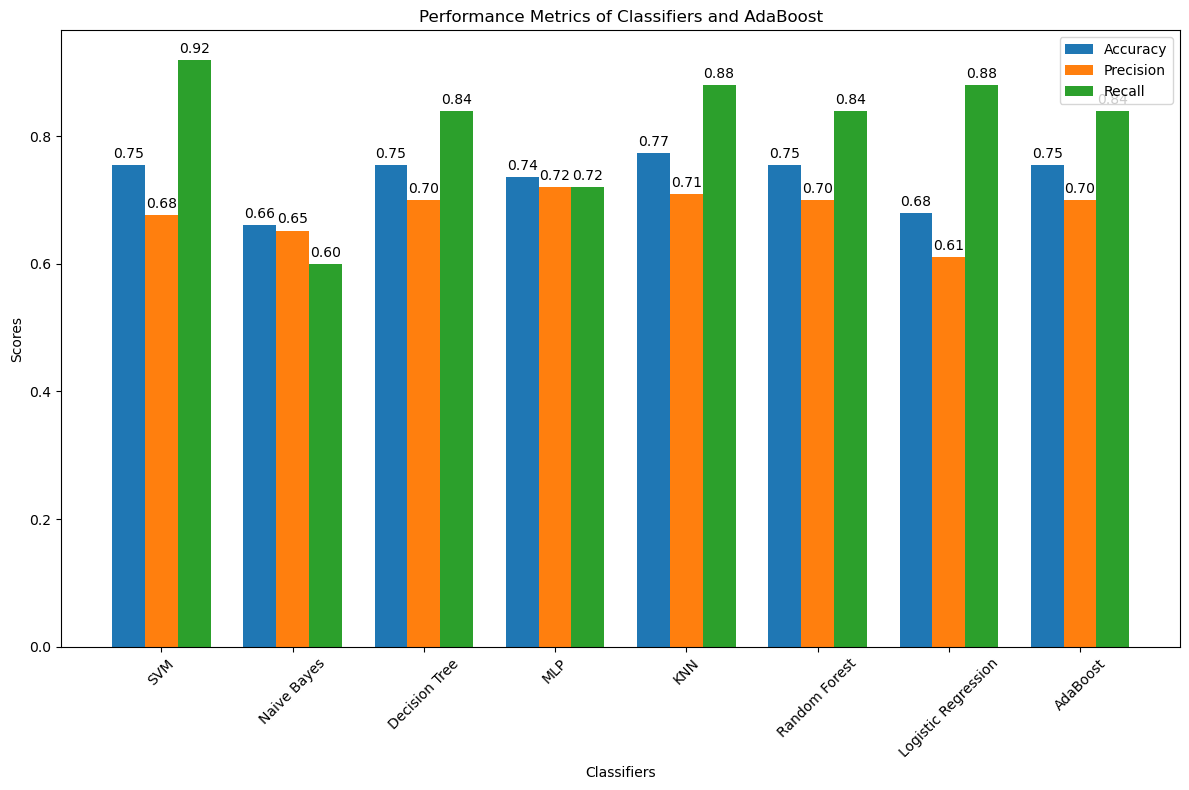

In [138]:
# Sample data (replace with your actual metrics)
y_preds = {
    'SVM': svm_test_preds,
    'Naive Bayes': nb_test_preds,
    'Decision Tree': dt_test_preds,
    'MLP': mlp_test_preds,
    'KNN': knn_test_preds,
    'Random Forest': rf_test_preds,
    'Logistic Regression': lr_test_preds,
    'AdaBoost': adaboost_test_preds
}

# Calculate accuracy, precision, and recall for each classifier
accuracy_scores = {stp_name: accuracy_score(y_test, y_preds[stp_name]) for stp_name in y_preds}
precision_scores = {stp_name: precision_score(y_test, y_preds[stp_name]) for stp_name in y_preds}
recall_scores = {stp_name: recall_score(y_test, y_preds[stp_name]) for stp_name in y_preds}

# Plotting
labels = list(y_preds.keys())
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(x - width, [accuracy_scores[stp_name] for stp_name in labels], width, label='Accuracy')
rects2 = ax.bar(x, [precision_scores[stp_name] for stp_name in labels], width, label='Precision')
rects3 = ax.bar(x + width, [recall_scores[stp_name] for stp_name in labels], width, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Classifiers')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics of Classifiers and AdaBoost')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

# Function to add labels on top of the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

## 2.2. Plotting recall score including cross-validation [k=2, 5, 10]

In [139]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


# Define classifiers
classifiers = {
    'SVM': SVC(kernel='linear', random_state=42),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'MLP': MLPClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=5000),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

# Define k values
k_values = [2, 5, 10]

# Define scoring metrics (accuracy, precision, recall)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted')
}

# Perform cross-validation
results = {}
for stp_name, stp in classifiers.items():
    stp_results = {}
    for k in k_values:
        cv = KFold(n_splits=k, shuffle=True, random_state=42)
        scores_accuracy = cross_val_score(stp, X, y, cv=cv, scoring='accuracy')
        scores_precision = cross_val_score(stp, X, y, cv=cv, scoring='precision_weighted')
        scores_recall = cross_val_score(stp, X, y, cv=cv, scoring='recall_weighted')
        
        stp_results[k] = {
            'accuracy': np.mean(scores_accuracy),
            'precision': np.mean(scores_precision),
            'recall': np.mean(scores_recall)
        }
    
    results[stp_name] = stp_results

# Print results (you can also store or visualize them)
for stp_name, stp_result in results.items():
    print(f"{stp_name}:")
    for k, metrics in stp_result.items():
        print(f"  k={k}: Accuracy={metrics['accuracy']:.3f}, Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}")
    print()

SVM:
  k=2: Accuracy=0.759, Precision=0.761, Recall=0.759
  k=5: Accuracy=0.810, Precision=0.816, Recall=0.810
  k=10: Accuracy=0.816, Precision=0.825, Recall=0.816

Naive Bayes:
  k=2: Accuracy=0.839, Precision=0.847, Recall=0.839
  k=5: Accuracy=0.874, Precision=0.876, Recall=0.874
  k=10: Accuracy=0.885, Precision=0.895, Recall=0.885

Decision Tree:
  k=2: Accuracy=0.759, Precision=0.760, Recall=0.759
  k=5: Accuracy=0.793, Precision=0.806, Recall=0.793
  k=10: Accuracy=0.776, Precision=0.807, Recall=0.776

MLP:
  k=2: Accuracy=0.816, Precision=0.817, Recall=0.816
  k=5: Accuracy=0.845, Precision=0.853, Recall=0.845
  k=10: Accuracy=0.834, Precision=0.852, Recall=0.834

KNN:
  k=2: Accuracy=0.701, Precision=0.757, Recall=0.701
  k=5: Accuracy=0.713, Precision=0.766, Recall=0.713
  k=10: Accuracy=0.735, Precision=0.787, Recall=0.735

Random Forest:
  k=2: Accuracy=0.862, Precision=0.863, Recall=0.862
  k=5: Accuracy=0.844, Precision=0.851, Recall=0.844
  k=10: Accuracy=0.913, Precisi

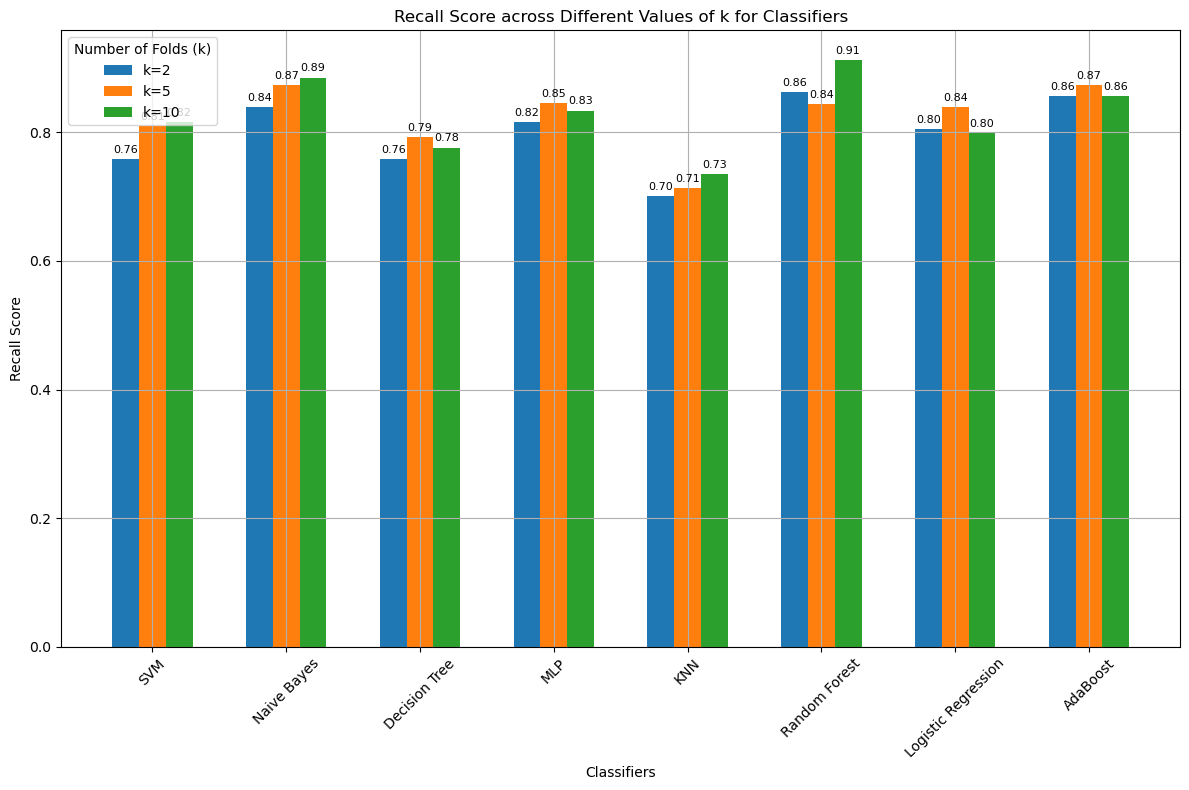

In [140]:
# Initialize empty dictionaries to store recall scores for each k
recall_scores = {2: {}, 5: {}, 10: {}}

# Populate recall_scores dictionary from 'results'
for stp_name, stp_result in results.items():
    for k, metrics in stp_result.items():
        recall_scores[k][stp_name] = metrics['recall']

# Prepare data for plotting
classifiers = list(results.keys())
k_values = [2, 5, 10]
recall_data = [[recall_scores[k][stp] for stp in classifiers] for k in k_values]

# Plotting
plt.figure(figsize=(12, 8))

bar_width = 0.2
x = np.arange(len(classifiers))

rects_list = []
for i, k in enumerate(k_values):
    rects = plt.bar(x + i * bar_width, recall_data[i], width=bar_width, label=f'k={k}')
    rects_list.append(rects)

plt.xlabel('Classifiers')
plt.ylabel('Recall Score')
plt.title('Recall Score across Different Values of k for Classifiers')
plt.xticks(x + bar_width, classifiers, rotation=45)
plt.legend(title='Number of Folds (k)')
plt.grid(True)
plt.tight_layout()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.2f}',
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom',
                     fontsize=8)

# Apply autolabel to each group of bars
for rects in rects_list:
    autolabel(rects)

plt.show()

## Best clasifier: Random Forest

In [141]:
final_stp_9 =  RandomForestClassifier(n_estimators=100, random_state=42)
final_stp_9.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [142]:
# Evaluate the final classifier
final_pred = final_stp_9.predict(X_test)
final_accuracy = accuracy_score(y_test, final_pred)
print(f"Final model accuracy with top features: {final_accuracy}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, final_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report for more detailed evaluation
class_report = classification_report(y_test, final_pred, target_names=['H', 'P'])
print("Classification Report:")
print(class_report)

Final model accuracy with top features: 0.8490566037735849
Confusion Matrix:
[[23  5]
 [ 3 22]]
Classification Report:
              precision    recall  f1-score   support

           H       0.88      0.82      0.85        28
           P       0.81      0.88      0.85        25

    accuracy                           0.85        53
   macro avg       0.85      0.85      0.85        53
weighted avg       0.85      0.85      0.85        53



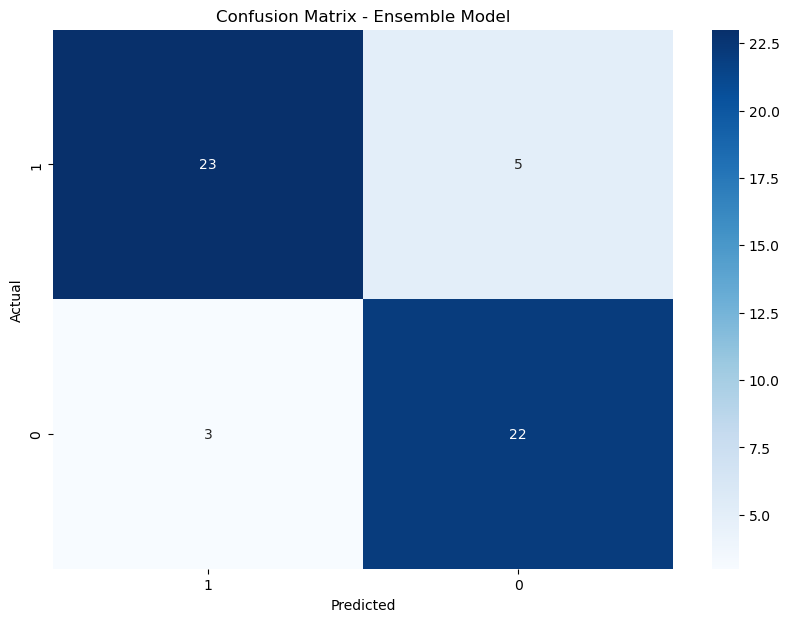

In [143]:
cm = confusion_matrix(y_test, final_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Ensemble Model')
plt.show()

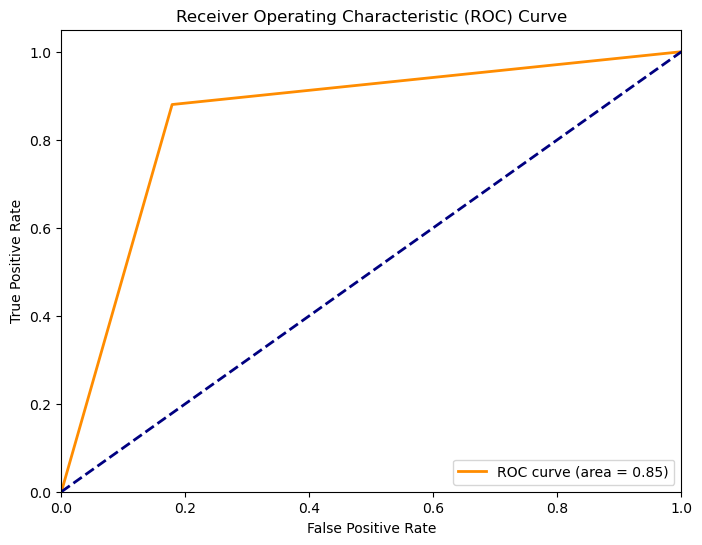

In [144]:
fpr, tpr, _ = roc_curve(y_test, final_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()